In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
ipl_data = pd.read_csv("matches.csv")

In [3]:
# Data Pre-processing
# Remove unnecessary columns
ipl_data = ipl_data.drop(columns=["umpire3", "umpire1", "umpire2", "venue", "dl_applied", "result"])

In [4]:
# Convert date to numeric (Unix timestamp)
ipl_data["date"] = pd.to_datetime(ipl_data["date"]).astype('int64') / 10**9

In [5]:
# Convert categorical columns to numeric using LabelEncoder
categorical_columns = ["city", "team1", "team2", "toss_winner", "toss_decision", "player_of_match", "winner"]
for col in categorical_columns:
    ipl_data[col] = LabelEncoder().fit_transform(ipl_data[col])

In [6]:
# Remove rows with NA values in 'winner' and 'player_of_match'
ipl_data = ipl_data.dropna(subset=["winner", "player_of_match"])


In [7]:
# Feature Engineering
# Create new features
ipl_data["team_strength"] = ipl_data["team1"] + ipl_data["team2"]
ipl_data["toss_win_team"] = (ipl_data["toss_winner"] == ipl_data["winner"]).astype(int)

In [8]:
# Feature Selection using Boruta
X = ipl_data.drop(columns=["winner"])
y = ipl_data["winner"]

In [9]:
# Initialize Boruta
rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42)
boruta.fit(X.values, y.values)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	4
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration:

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=84,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x23478BBBB40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x23478BBBB40, verbose=2)

In [10]:
# Get selected features
selected_features = X.columns[boruta.support_].to_list()
print("Selected Features:", selected_features)


Selected Features: ['team1', 'team2', 'toss_winner', 'win_by_runs', 'win_by_wickets', 'player_of_match', 'team_strength']


In [11]:
# Filter dataset with selected features
X = X[selected_features]


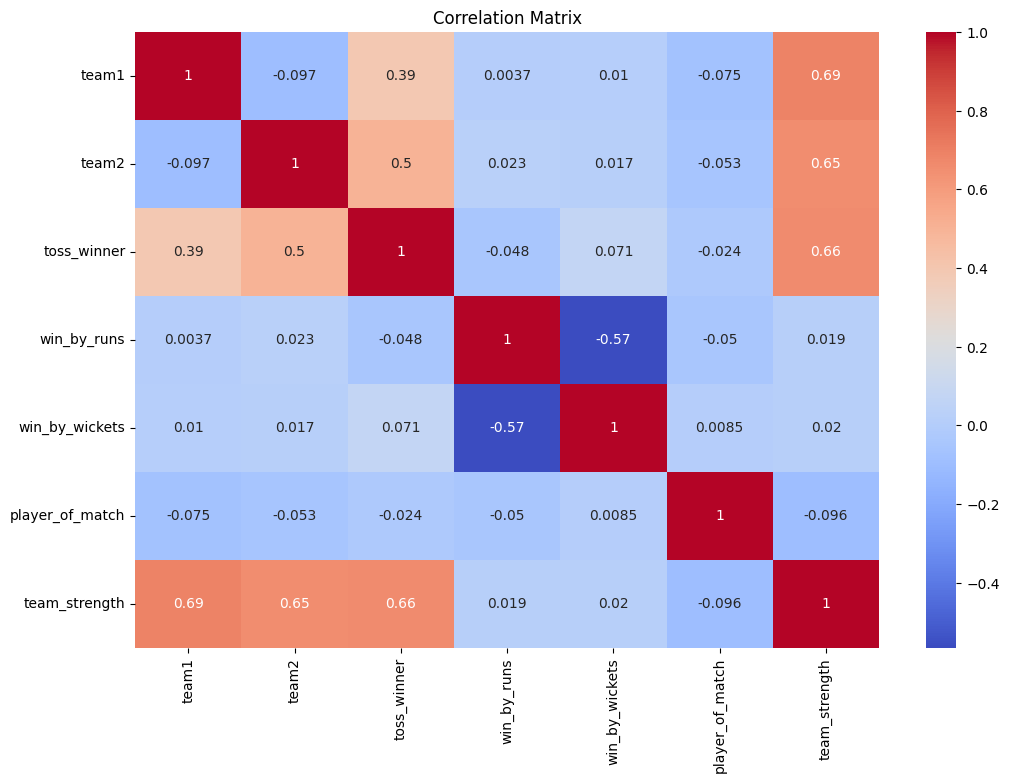

In [12]:
# Data Visualization
# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

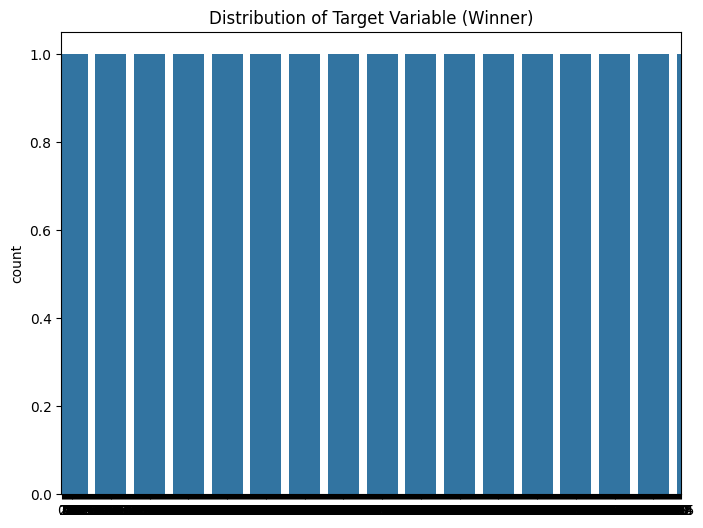

In [13]:
# Plot distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(y)
plt.title("Distribution of Target Variable (Winner)")
plt.show()

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predict = dt_model.predict(X_test)
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, dt_predict))
print("Decision Tree Classification Report:\n", classification_report(y_test, dt_predict))

Decision Tree Confusion Matrix:
 [[18  2  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 1  2  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0 13  0  0  1  0  1  0  0]
 [ 0  0  0  0  1  0  0 13  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  1 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  2  0  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80        22
           1       0.50      0.50      0.50         4
           2       0.64      0.78      0.70         9
           3       1.00      0.20      0.33         5
           4       0.67    

C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [17]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
rf_predict = rf_model.predict(X_test)
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_predict))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predict))

Random Forest Confusion Matrix:
 [[22  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  1  1  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  6  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.75      0.86         4
           2       0.69      1.00      0.82         9
           3       1.00      0.60      0.75         5
           4       1.00      0.92      0.96        13
           6       1.00      0.94      0.97        17
   

C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [18]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predict = nb_model.predict(X_test)
print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, nb_predict))
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predict))

Naive Bayes Confusion Matrix:
 [[13  1  7  0  0  0  0  0  0  1  0  0  0  0]
 [ 1  2  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  7  0  1  0  1  2  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  4  0  2  4  0  2  0  0  0  2  2  0]
 [ 4  1  1  0  1  0  0  5  0  2  0  0  1  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  2  0  1  0  1  5  0  1  0  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0  1  0]
 [ 0  1  2  0  1  0  0  0  0  1  2  8  2  0]
 [ 0  0  0  0  0  0  0  1  0  1  0  4  1  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]]
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59        22
           1       0.22      0.50      0.31         4
           2       0.20      0.67      0.31         9
           3       1.00      0.80      0.89         5
           4       0.17      0.

C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [19]:
# K-Nearest Neighbor
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predict = knn_model.predict(X_test)
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, knn_predict))
print("KNN Classification Report:\n", classification_report(y_test, knn_predict))

KNN Confusion Matrix:
 [[14  1  4  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  5  2  2  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  1  1  0  1  0  0  0  0  0  0  0  0]
 [ 1  0  2  2  3  0  2  1  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  4  1  4  2  0  2  0  0  2  0  0]
 [ 3  0  2  0  3  0  3  3  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  1  2  7  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  6  0  0  2  0  0  6  1  0]
 [ 0  0  0  1  0  0  1  2  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.65        22
           1       0.33      0.25      0.29         4
           2       0.29      0.56      0.38         9
           

C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [20]:
# Deep Learning Model
# Define the DL model
dl_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(np.unique(y)), activation="softmax")
])

C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile the model
dl_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model
history = dl_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1210 - loss: 2.6541 - val_accuracy: 0.2843 - val_loss: 2.5535
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1905 - loss: 2.5431 - val_accuracy: 0.2549 - val_loss: 2.4222
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2321 - loss: 2.4252 - val_accuracy: 0.2451 - val_loss: 2.2648
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2293 - loss: 2.2803 - val_accuracy: 0.2647 - val_loss: 2.1355
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2352 - loss: 2.1775 - val_accuracy: 0.2941 - val_loss: 2.0411
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2965 - loss: 2.0218 - val_accuracy: 0.2059 - val_loss: 1.9758
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2933 - loss: 2.0305 - val_accuracy: 0.2745 - val_loss: 1.9108
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3416 - loss: 1.9194 - val_accuracy: 0.2843 - 

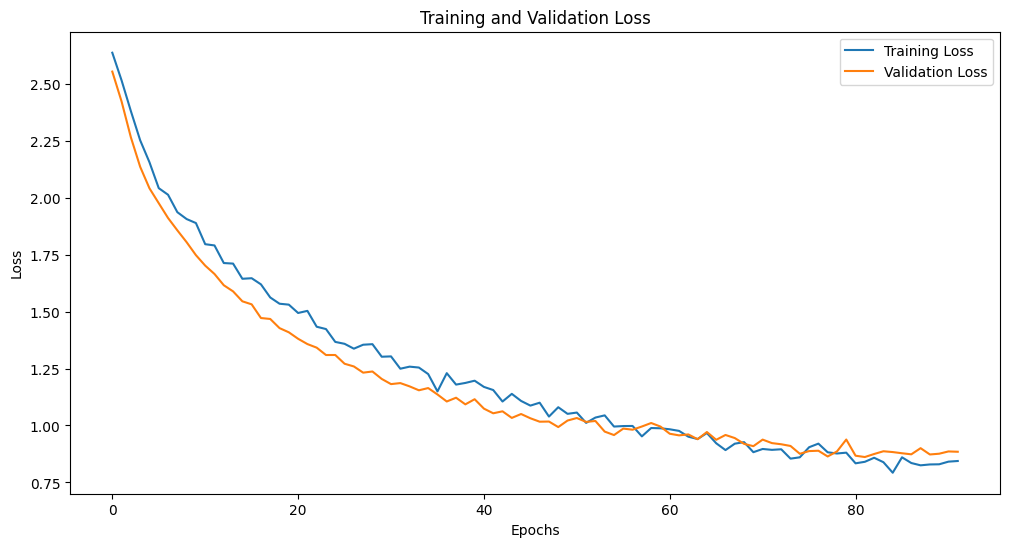

In [22]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
# Evaluate the model
dl_predict = np.argmax(dl_model.predict(X_test_scaled), axis=1)
print("Deep Learning Confusion Matrix:\n", confusion_matrix(y_test, dl_predict))
print("Deep Learning Classification Report:\n", classification_report(y_test, dl_predict))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Deep Learning Confusion Matrix:
 [[22  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 13  3  0  1  0  0  0  0]
 [ 0  1  0  0  1  1 12  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  4  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0]]
Deep Learning Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       0.67      0.50      0.57         4
           2       0.90      1.00      0.95         9
           3       1.00      0.20      0.33         5
           4       0.72      1.00      0.84        13
           6       

C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\prama\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo